### Assignment: Term Project MileStone 5
#### Name: Vidya Praveen

#### Merging the Data and Storing in a Database/Visualizing Data

Now that you have cleaned and transformed your 3 datasets, you need to load them into a database. You can choose what kind of database (SQLLite or MySQL, Postgre SQL are all free options). You will want to load each dataset into SQL Lite as an individual table and then you must join the datasets together in Python into 1 dataset.

Once all the data is merged together in your database, create 5 visualizations that demonstrate the data you have cleansed. You should have at least 2 visualizations that have data from more than one source (meaning, if you have 3 tables, you must have visualizations that span across 2 of the tables – you are also welcome to use your consolidated dataset that you created in the previous step, if you do that, you have met this requirement).

For the visualization portion of the project, you are welcome to use a python library like Matplotlib, Seaborn, or an R package ggPlot2, Plotly, or Tableau/PowerBI.


Clearly label each visualization. Submit your code for merging and storing in the database, with your code for the visualizations along with a 250-500-word summary of what you learned and had to do to complete the project. In your write-up, make sure to address the ethical implications of cleansing data and your project topic


#### CSV Dataset

CSV – The Covid 19 data is scrapped from John Hopkins University github repo : https://github.com/CSSEGISandData/COVID19/tree/master/csse_covid_19_data/csse_covid_19_time_series , this has Daily time series
summary tables, including confirmed, deaths and recovered. All data is read in from the daily case report. The time series tables are subject to be updated if inaccuracies are identified in our historical data. Two time series tables are for the US confirmed cases and deaths, reported at the county level. Three time series tables are for the global confirmed cases, recovered cases and deaths. Australia, Canada and China are reported at the province/state level. Data is updated at
a daily basis.

In [1]:
# import libraries
# for date and time opeations
from datetime import datetime, timedelta
# for file and folder operations
import os
# for regular expression operations
import re
1
# for listing files in a folder
import glob
# for getting web contents
import requests
# storing and analysing data
import pandas as pd
# for scraping web contents
from bs4 import BeautifulSoup
# numerical analysis
import numpy as np


In [2]:
# Read dataset
conf_df = pd.read_csv('..\\data\\raw\\time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('..\\data\\raw\\time_series_covid19_deaths_global.csv')
recv_df = pd.read_csv('..\\data\\raw\\time_series_covid19_recovered_global.csv')
usdeaths_df = pd.read_csv("..\\data\\raw\\time_series_covid19_deaths_US.csv")
usconf_df = pd.read_csv('..\\data\\raw\\time_series_covid19_confirmed_US.csv')
uscountydata = pd.read_csv('..\\data\\raw\\usa_county_wise.csv')

uscountydatagrouped = uscountydata.groupby(['Admin2'])['Confirmed','Deaths'].max()



C:\Users\vidya\AppData\Local\Temp\ipykernel_7672\2236135517.py:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  uscountydatagrouped = uscountydata.groupby(['Admin2'])['Confirmed','Deaths'].max()


In [3]:
# Merge the datasets
# extract dates
dates = conf_df.columns[4:]
# melt dataframes into longer format
conf_df_long = conf_df.melt(id_vars=['Province/State', 'Country/Region', 'Lat','Long'],value_vars=dates, var_name='Date',value_name='Confirmed')
deaths_df_long = deaths_df.melt(id_vars=['Province/State', 'Country/Region','Lat', 'Long'],value_vars=dates, var_name='Date',value_name='Deaths')
recv_df_long = recv_df.melt(id_vars=['Province/State', 'Country/Region', 'Lat','Long'],value_vars=dates, var_name='Date',value_name='Recovered')

print(conf_df_long.shape)
print(deaths_df_long.shape)
print(recv_df_long.shape)


(330327, 6)
(330327, 6)
(313182, 6)


In [4]:
# merge dataframes to get a full dataframe, we will then perform a cleanup on the final dataset
full_table = pd.merge(left=conf_df_long, right=deaths_df_long, how='left',
on=['Province/State', 'Country/Region', 'Date', 'Lat','Long'])
full_table = pd.merge(left=full_table, right=recv_df_long, how='left',
on=['Province/State', 'Country/Region', 'Date', 'Lat','Long'])
full_table.head()


,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,NaN,Afghanistan,33.93911,67.709953,1/22/20,0,0,0.0
1,NaN,Albania,41.15330,20.168300,1/22/20,0,0,0.0
2,NaN,Algeria,28.03390,1.659600,1/22/20,0,0,0.0
3,NaN,Andorra,42.50630,1.521800,1/22/20,0,0,0.0
4,NaN,Angola,-11.20270,17.873900,1/22/20,0,0,0.0


In [5]:
# 1. Convert to proper date format
full_table['Date'] = pd.to_datetime(full_table['Date'])

# 2. fill na with 0
full_table['Recovered'] = full_table['Recovered'].fillna(0)

# 3. convert to int datatype
full_table['Recovered'] = full_table['Recovered'].astype('int')

# 4. fixing Country names

# 4.1 renaming countries, regions, provinces
full_table['Country/Region'] = full_table['Country/Region'].replace('Korea,South', 'South Korea')

# 4.2 Greenland
full_table.loc[full_table['Province/State']=='Greenland', 'Country/Region'] ='Greenland'

# 4.3 Mainland china to China
full_table['Country/Region'] = full_table['Country/Region'].replace('MainlandChina', 'China')

# 5. Removing county wise data to avoid double counting
full_table = full_table[full_table['Province/State'].str.contains(',')!=True]


In [6]:
# Active Case = confirmed - deaths - recovered
full_table['Active'] = full_table['Confirmed'] - full_table['Deaths'] -full_table['Recovered']

# filling missing values

# fill missing province/state value with ''
full_table[['Province/State']] = full_table[['Province/State']].fillna('')

# fill missing numerical values with 0
cols = ['Confirmed', 'Deaths', 'Recovered', 'Active']
full_table[cols] = full_table[cols].fillna(0)

# fixing datatypes
full_table['Recovered'] = full_table['Recovered'].astype(int)

# Viewing sample rows
full_table.sample(6)


,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active
109712,,Malta,35.937500,14.375400,2021-02-04,18385,273,15567,2545
79592,,Ethiopia,9.145000,40.489700,2020-10-23,92229,1400,46118,44711
212339,,Papua New Guinea,-6.314993,143.955550,2022-01-25,36548,597,0,35951
87798,,Serbia,44.016500,21.005900,2020-11-20,110351,1140,0,109211
203029,,Iraq,33.223191,43.679291,2021-12-24,2092156,24115,0,2068041
163928,Guangxi,China,23.829800,108.788100,2021-08-11,280,2,0,278


In [7]:
# function to change value of a column in dataframe
def change_val(date, ref_col, val_col, dtnry):
    for key, val in dtnry.items():
        full_table.loc[(full_table['Date']==date) & (full_table[ref_col]==key),val_col] = val


In [8]:
# we found that hubei province in China has incorrect data,
# lets see what it is and will update it with correct one
# checking values
full_table[(full_table['Date']=='2/12/20') & (full_table['Province/State']=='Hubei')]


,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active
6141,Hubei,China,30.9756,112.2707,2020-02-12,33366,1068,2686,29612


In [9]:
# The confirmed deaths need to be updated to 34874 as per the latest info, we will do that update
feb_12_conf = {'Hubei' : 34874}
change_val('2/12/20', 'Province/State', 'Confirmed', feb_12_conf)


In [10]:
# there is ship rows info which contains ships with Covid-19 reported cases
# this is an outlier for our analysis so we will remove that info from our dataframe

# ship rows containing ships with COVID-19 reported cases
ship_rows = full_table['Province/State'].str.contains('Grand Princess') | \
            full_table['Province/State'].str.contains('Diamond Princess') | \
            full_table['Country/Region'].str.contains('Diamond Princess') | \
            full_table['Country/Region'].str.contains('MS Zaandam')

# ship
ship = full_table[ship_rows]

# Latest cases from the ships
ship_latest = ship[ship['Date']==max(ship['Date'])]

# ship_latest.style.background_gradient(cmap='Pastel1_r')

# skipping rows with ships info
csv_datafame = full_table[~(ship_rows)]
csv_datafame


,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active
0,,Afghanistan,33.939110,67.709953,2020-01-22,0,0,0,0
1,,Albania,41.153300,20.168300,2020-01-22,0,0,0,0
2,,Algeria,28.033900,1.659600,2020-01-22,0,0,0,0
3,,Andorra,42.506300,1.521800,2020-01-22,0,0,0,0
4,,Angola,-11.202700,17.873900,2020-01-22,0,0,0,0
...,...,...,...,...,...,...,...,...,...
330322,,West Bank and Gaza,31.952200,35.233200,2023-03-09,703228,5708,0,697520
330323,,Winter Olympics 2022,39.904200,116.407400,2023-03-09,535,0,0,535
330324,,Yemen,15.552727,48.516388,2023-03-09,11945,2159,0,9786
330325,,Zambia,-13.133897,27.849332,2023-03-09,343135,4057,0,339078


#### HTML Dataset


HTML - I will be scrapping data from https://www.worldometers.info/coronavirus/#countries
to get the covid details for all countries

In [11]:
#import libraries
import os, sys
import json
import pandas as pd
import numpy as np
from numpy import int64
import requests, io
import urllib.request
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

# Basic plotting packages
import matplotlib.pyplot as plt

# advanced ploting
import seaborn as sns

# interactive visualization
import plotly.express as px
import plotly.graph_objs as go
# import plotly.figure_factory as ff
from plotly.subplots import make_subplots

In [12]:
url = "https://www.worldometers.info/coronavirus/#countries"
response = requests.get(url)

class HTMLTableParser:

    def parse_url(self, url):
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'lxml')
        return [(table['id'], self.parse_html_table(table))
                for table in soup.find_all('table')]

    def parse_html_table(self, table):
        n_columns = 0
        n_rows = 0
        column_names = []

        for row in table.find_all('tr'):
            td_tags = row.find_all('td')
            if len(td_tags) > 0:
                n_rows += 1
            if n_columns == 0:
                n_columns = len(td_tags)

            th_tags = row.find_all('th')
            if len(th_tags) > 0 and len(column_names) == 0:
                for th in th_tags:
                    colData = th.get_text()
                    colData = colData.replace('/', '').replace(' ', '').replace(',', '').replace('\n', '').replace(' ', '').replace('&nbsp;', '')
                    column_names.append(colData)

        if len(column_names) > 0 and len(column_names) != n_columns:
            raise Exception("Column titles do not match the number of columns")
        columns = column_names if len(column_names) > 0 else range(0, n_columns)
        df = pd.DataFrame(columns=columns,
                          index=range(0, n_rows))
        row_marker = 0
        for row in table.find_all('tr'):
            column_marker = 0
            columns = row.find_all('td')
            for column in columns:
                df.iat[row_marker, column_marker] = column.get_text()
                column_marker += 1
            if len(columns) > 0:
                row_marker += 1

        for col in df:
            try:
                df[col] = df[col].astype(float)
            except ValueError:
                pass
        return df



In [13]:
# Parsing Html data
hp = HTMLTableParser()
table = hp.parse_url(url)[0][1] # Grabbing the table from the tuple
table.head(10)


,#,CountryOther,TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,NewRecovered,ActiveCases,SeriousCritical,...,TotalTests,Tests1Mpop,Population,Continent,1CaseeveryXppl,1DeatheveryXppl,1TesteveryXppl,NewCases1Mpop,NewDeaths1Mpop,ActiveCases1Mpop
0,,\nNorth America\n,"131,889,132",,"1,695,941",,"127,665,129",+350,"2,528,062","6,095",...,,,,North America,\n,,,,,
1,,\nAsia\n,"221,500,265",,"1,553,662",,"205,673,091",,"14,273,512","14,733",...,,,,Asia,\n,,,,,
2,,\nEurope\n,"253,406,198",,"2,101,824",,"248,754,104",+474,"2,550,270","4,453",...,,,,Europe,\n,,,,,
3,,\nSouth America\n,"70,200,879",,"1,367,332",,"66,683,585",,"2,149,962","8,953",...,,,,South America,\n,,,,,
4,,\nOceania\n,"14,895,771",,"33,015",,"14,752,388",,"110,368",31,...,,,,Australia/Oceania,\n,,,,,
5,,\nAfrica\n,"12,860,924",,"258,892",,"12,090,808",,"511,224",529,...,,,,Africa,\n,,,,,
6,,\n\n,721,,15,,706,,0,0,...,,,,,\n,,,,,
7,,World,"704,753,890",0,"7,010,681",0,"675,619,811",+790,"22,123,398","34,794",...,,,,All,\n,,,,,
8,1,USA,"111,820,082",,"1,219,487",,"109,814,428",,"786,167",940,...,"1,186,851,502","3,544,901","334,805,269",North America,3,275,0,,,"2,348"
9,2,India,"45,035,393",,"533,570",,N/A,N/A,N/A,N/A,...,"935,879,495","665,334","1,406,631,776",Asia,31,"2,636",2,,,0.4


In [14]:
# There are some extra special characters (\n..\n) in the dataframe.
# We need to remove the extra characters. We only need country data for mapping in this tutorial.
# So we can drop the extra top and bottom rows that we do not need for data processing.

#Drop top buttom unwanted rows
df= table.drop(table.index[[0,1,2,3,4,5,6,7]]).reset_index(drop=True)
#drop tail unwanted rows
df.drop(df.tail(8).index,inplace=True)
#drop new line '\n' charachter
df.replace(['\n'], '', regex=True, inplace=True)
df.replace([','], '', regex=True, inplace=True)

In [15]:
#We need to format the table before starting mapping.
# The special characters in the dataframe can be removed using a loop as below:
# drop unwanted drop unwanted special characters using a loop
for col in df.columns[0:20]:
    df[col]=df[col].str.replace('+', '').str.replace(',', '').str.replace('N/A', '').str.replace(' ', '').str.replace(' ', '').str.replace('&nbsp;', '')


C:\Users\vidya\AppData\Local\Temp\ipykernel_7672\1845198198.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[col]=df[col].str.replace('+', '').str.replace(',', '').str.replace('N/A', '').str.replace(' ', '').str.replace(' ', '').str.replace('&nbsp;', '')


In [16]:
# All the extracted data is in text format and some column names are improper for data processing.
# We need to rename some column names.
html_dataframe = df.rename(columns={'CountryOther': 'Country_Name','SeriousCritical': 'Serious_Critical', 'Tot Cases1Mpop': 'Tot_Cases_1M_pop','Deaths1Mpop': 'Deaths_1M_pop', 'Tests1Mpop': 'Tests_1M_pop'})
html_dataframe.head()

,#,Country_Name,TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,NewRecovered,ActiveCases,Serious_Critical,...,TotalTests,Tests_1M_pop,Population,Continent,1CaseeveryXppl,1DeatheveryXppl,1TesteveryXppl,NewCases1Mpop,NewDeaths1Mpop,ActiveCases1Mpop
0,1,USA,111820082,,1219487,,109814428,,786167,940,...,1186851502,3544901,334805269,NorthAmerica,3,275,0,,,2348
1,2,India,45035393,,533570,,,,,,...,935879495,665334,1406631776,Asia,31,2636,2,,,0.4
2,3,France,40138560,,167642,,39970918,,0,,...,271490188,4139547,65584518,Europe,2,391,0,,,
3,4,Germany,38828995,,183027,,38240600,,405368,,...,122332384,1458359,83883596,Europe,2,458,1,,,4833
4,5,Brazil,38743918,,711380,,36249161,,1783377,,...,63776166,296146,215353593,SouthAmerica,6,303,3,,,8281


#### API Dataset

API - I will be fetchng data from https://api.census.gov/data/2019/acs/acs1/profile?get=NAME,group(DP02)&for=county:* 
which will provide the demographic info (Age, employment, sex, ethnicity etc ) for US at a County level for all the corona virus cases, this information is vital to understand the rate of spread across communities in United States. I will use this data to deep dive into corona cases in US and generate some interesting facts.


Load the necessary libraries.

In [17]:
#import libraries
import urllib.request, urllib.parse, urllib.error
import json
import requests
import numpy as np
import pandas as pd
#pandasql package allows us to write SQL querry on Pandas DataFrame
import pandasql as psql
import seaborn as sns
import matplotlib.pyplot as plt

Reading the API data


In [18]:
apiURl = "https://api.census.gov/data/2019/acs/acs1/profile?get=NAME,group(DP02)&for=county:*"
filename = "..\\results\\acs2019_county_data.csv"
chunk_size = 100

response = requests.get(apiURl)

# calling this API and saving it as CSV
with open(filename, 'wb') as fd:
    for chunk in response.iter_content(chunk_size):
        fd.write(chunk)


In [19]:
county_2019 = pd.read_csv('..\\results\\acs2019_county_data.csv', encoding='latin-1')
county_2019.head()


C:\Users\vidya\AppData\Local\Temp\ipykernel_7672\3570763012.py:1: DtypeWarning: Columns (19,21,23,25,141) have mixed types. Specify dtype option on import or set low_memory=False.
  county_2019 = pd.read_csv('..\\results\\acs2019_county_data.csv', encoding='latin-1')


,"[[""NAME""",DP02_0001E,DP02_0001EA,DP02_0001M,DP02_0001MA,DP02_0001PE,DP02_0001PEA,DP02_0001PM,DP02_0001PMA,DP02_0002E,...,DP02_0153MA,DP02_0153PE,DP02_0153PEA,DP02_0153PM,DP02_0153PMA,GEO_ID,NAME,state,county],Unnamed: 1229
"[""Jefferson County","Kentucky""",316174.0,NaN,3159.0,NaN,316174.0,NaN,-888888888.0,(X),129152.0,...,NaN,87.4,NaN,1.0,NaN,0500000US21111,"Jefferson County, Kentucky",21,111],NaN
"[""Hennepin County","Minnesota""",517091.0,NaN,3530.0,NaN,517091.0,NaN,-888888888.0,(X),227734.0,...,NaN,89.6,NaN,0.6,NaN,0500000US27053,"Hennepin County, Minnesota",27,053],NaN
"[""Olmsted County","Minnesota""",65635.0,NaN,1105.0,NaN,65635.0,NaN,-888888888.0,(X),33798.0,...,NaN,89.1,NaN,2.1,NaN,0500000US27109,"Olmsted County, Minnesota",27,109],NaN
"[""Scott County","Minnesota""",51474.0,NaN,737.0,NaN,51474.0,NaN,-888888888.0,(X),30406.0,...,NaN,93.6,NaN,1.9,NaN,0500000US27139,"Scott County, Minnesota",27,139],NaN
"[""Faulkner County","Arkansas""",47389.0,NaN,1263.0,NaN,47389.0,NaN,-888888888.0,(X),23130.0,...,NaN,93.2,NaN,1.9,NaN,0500000US05045,"Faulkner County, Arkansas",5,045],NaN


In [20]:
county_2019.describe(include = 'all')


,"[[""NAME""",DP02_0001E,DP02_0001EA,DP02_0001M,DP02_0001MA,DP02_0001PE,DP02_0001PEA,DP02_0001PM,DP02_0001PMA,DP02_0002E,...,DP02_0153MA,DP02_0153PE,DP02_0153PEA,DP02_0153PM,DP02_0153PMA,GEO_ID,NAME,state,county],Unnamed: 1229
count,840,8.290000e+02,0.0,829.000000,0.0,8.290000e+02,0.0,829.0,829,8.290000e+02,...,0.0,829.000000,0.0,829.000000,0.0,840,840,840.000000,840,0.0
unique,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,...,NaN,NaN,NaN,NaN,NaN,840,840,NaN,157,NaN
top,"Texas""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,(X),NaN,...,NaN,NaN,NaN,NaN,NaN,0500000US21111,"Jefferson County, Kentucky",NaN,005],NaN
freq,54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,829,NaN,...,NaN,NaN,NaN,NaN,NaN,1,1,NaN,22,NaN
mean,NaN,1.252114e+05,NaN,2035.389626,NaN,1.252114e+05,NaN,-888888888.0,NaN,5.901717e+04,...,NaN,85.979735,NaN,2.347648,NaN,NaN,NaN,30.433333,NaN,NaN
std,NaN,2.074759e+05,NaN,1180.137428,NaN,2.074759e+05,NaN,0.0,NaN,9.383417e+04,...,NaN,5.706501,NaN,1.085649,NaN,NaN,NaN,16.165129,NaN,NaN
min,NaN,2.076100e+04,NaN,520.000000,NaN,2.076100e+04,NaN,-888888888.0,NaN,7.201000e+03,...,NaN,34.700000,NaN,0.200000,NaN,NaN,NaN,1.000000,NaN,NaN
25%,NaN,3.678800e+04,NaN,1323.000000,NaN,3.678800e+04,NaN,-888888888.0,NaN,1.809500e+04,...,NaN,83.300000,NaN,1.500000,NaN,NaN,NaN,17.000000,NaN,NaN
50%,NaN,6.087500e+04,NaN,1694.000000,NaN,6.087500e+04,NaN,-888888888.0,NaN,2.982300e+04,...,NaN,86.700000,NaN,2.200000,NaN,NaN,NaN,34.000000,NaN,NaN
75%,NaN,1.289200e+05,NaN,2403.000000,NaN,1.289200e+05,NaN,-888888888.0,NaN,6.128100e+04,...,NaN,89.600000,NaN,3.000000,NaN,NaN,NaN,42.000000,NaN,NaN


In [21]:
#subsetting dataset to get relevant columns
County2019 = county_2019[['DP02_0001E','DP02_0031E','DP02_0053E','DP02_0062E','DP02_0087E','DP02_0094E']]
County2019.head()



,DP02_0001E,DP02_0031E,DP02_0053E,DP02_0062E,DP02_0087E,DP02_0094E
"[""Jefferson County",316174.0,328084.0,173361.0,142555.0,766757.0,70265.0
"[""Hennepin County",517091.0,525059.0,307409.0,145356.0,1265843.0,167523.0
"[""Olmsted County",65635.0,65366.0,37198.0,22424.0,158293.0,17476.0
"[""Scott County",51474.0,57625.0,41855.0,20015.0,149013.0,14529.0
"[""Faulkner County",47389.0,53740.0,37236.0,24953.0,126007.0,3246.0


In [22]:

# Create a copy of the DataFrame to avoid the warning
County2019_copy = County2019.copy()

# Define the new column names
new_column_names = {
    'DP02_0001E': 'Total Household',
    'DP02_0031E': 'Male percentage',
    'DP02_0053E': 'Female percentage',
    'DP02_0062E': 'Percentage married',
    'DP02_0087E': 'Estimate place of birth',
    'DP02_0094E': 'Percentage citizenship status'
}

# Rename the columns using .rename() and assign the result back to County2019
County2019 = County2019.rename(columns=new_column_names)

# Print the first few rows of the modified DataFrame
print(County2019.head())


api_dataframe = County2019
api_dataframe.head()

                    Total Household  Male percentage  Female percentage  \
["Jefferson County         316174.0         328084.0           173361.0   
["Hennepin County          517091.0         525059.0           307409.0   
["Olmsted County            65635.0          65366.0            37198.0   
["Scott County              51474.0          57625.0            41855.0   
["Faulkner County           47389.0          53740.0            37236.0   

                    Percentage married  Estimate place of birth  \
["Jefferson County            142555.0                 766757.0   
["Hennepin County             145356.0                1265843.0   
["Olmsted County               22424.0                 158293.0   
["Scott County                 20015.0                 149013.0   
["Faulkner County              24953.0                 126007.0   

                    Percentage citizenship status  
["Jefferson County                        70265.0  
["Hennepin County                        1

,Total Household,Male percentage,Female percentage,Percentage married,Estimate place of birth,Percentage citizenship status
"[""Jefferson County",316174.0,328084.0,173361.0,142555.0,766757.0,70265.0
"[""Hennepin County",517091.0,525059.0,307409.0,145356.0,1265843.0,167523.0
"[""Olmsted County",65635.0,65366.0,37198.0,22424.0,158293.0,17476.0
"[""Scott County",51474.0,57625.0,41855.0,20015.0,149013.0,14529.0
"[""Faulkner County",47389.0,53740.0,37236.0,24953.0,126007.0,3246.0


In [23]:
# Aggregating csv dataset based on
cols = ['Country/Region','Date','Confirmed','Deaths', 'Recovered', 'Active']
csv_selected_datafame = csv_datafame[cols]
csv_agg = csv_selected_datafame.groupby(['Country/Region','Confirmed','Deaths', 'Recovered', 'Active'])['Date'].max()
csv_agg = csv_selected_datafame.groupby(['Country/Region'])['Confirmed','Deaths', 'Recovered', 'Active'].sum()
csv_agg['Confirmed'] = csv_agg['Confirmed']/100
csv_agg['Deaths'] = csv_agg['Deaths']/100
csv_agg['Recovered'] = csv_agg['Recovered']/100
csv_agg['Active'] = csv_agg['Active']/100


C:\Users\vidya\AppData\Local\Temp\ipykernel_7672\3659645471.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  csv_agg = csv_selected_datafame.groupby(['Country/Region'])['Confirmed','Deaths', 'Recovered', 'Active'].sum()


In [24]:
# Adding Country column in API dataset
api_dataframe['Country']='USA'
api_dataframe['CountryShort']='US'


### Inserting all the 3 datasets into MySQL table

In [25]:
 # importing sqlite3 library
import sqlalchemy
from sqlalchemy import create_engine , select, MetaData, Table, and_
import pandas as pd
import sqlite3


In [26]:
engine = sqlalchemy.create_engine('sqlite:///..//results//covidWorldResultDb.db', echo=False)


In [27]:
csv_agg.to_sql('CSVData', con=engine, if_exists='append')


200

In [28]:
 html_dataframe.to_sql('HTMLData', con=engine, if_exists='append')

231

In [29]:
api_dataframe.to_sql('APIData', con=engine, if_exists='append')


840

In [30]:
uscountydata.to_sql('CSVUSCounty', con=engine, if_exists='append')


627920

In [31]:
uscountydatagrouped.to_sql('CSVUSCountyGrouped', con=engine, if_exists='append')


1978

In [32]:
# Getting the US Country Covid and Demographic data by joining CSV and API Dataset
conn = sqlite3.connect('..\\results\\covidWorldDb.db')

# Creating CSV US County dataset
query = conn.execute('''SELECT a.* , b.* FROM CSVUSCountyGrouped as a inner join APIData as b on a.[Admin2] = b.County;''')
cols = [column[0] for column in query.description]
uscountyAPIDF = pd.DataFrame.from_records(data = query.fetchall(), columns =cols)

#commit the changes to db
conn.commit()

#close the connection
conn.close()


In [33]:
# Getting the US Country Covid Dataset
conn = sqlite3.connect('..\\results\\covidWorldDb.db')

# Creating CSV US County dataset
query = conn.execute('''SELECT a.* FROM CSVUSCounty as a;''')

cols = [column[0] for column in query.description]
uscountyDF = pd.DataFrame.from_records(data = query.fetchall(), columns = cols)

#commit the changes to db
conn.commit()

#close the connection
conn.close()


In [34]:
conn = sqlite3.connect('..\\results\\covidWorldDb.db')
#c = conn.cursor()

# Joining from CSV and HTML dataset

query = conn.execute('''SELECT a.*, b.* FROM CSVData as a inner join HTMLData as b on a.[Country/Region] = b.Country_Name;''')

#csvhtmlrows = c.fetchall()

cols = [column[0] for column in query.description]
csvhtmlDF = pd.DataFrame.from_records(data = query.fetchall(), columns = cols)

#for row in csvhtmlrows:
# print(row)

#commit the changes to db
conn.commit()

#close the connection
conn.close()


In [35]:
conn = sqlite3.connect('..\\results\\covidWorldDb.db')
#c = conn.cursor()

# Joining from CSV and HTML dataset
query = conn.execute('''SELECT a.* FROM CSVData as a;''')

#csvhtmlrows = c.fetchall()

cols = [column[0] for column in query.description]
csvDF = pd.DataFrame.from_records(data = query.fetchall(), columns = cols)

#for row in csvhtmlrows:
# print(row)

#commit the changes to db
conn.commit()
#close the connection
conn.close()

In [36]:
conn = sqlite3.connect('..\\results\\covidWorldDb.db')
#c = conn.cursor()

# Joining from CSV and HTML dataset
queryApi = conn.execute('''SELECT a.*, b.* FROM APIData as a inner join HTMLData as b on a.[Country] = b.Country_Name;''')

#apihtmlrows = c.fetchall()
cols = [column[0] for column in queryApi.description]
apihtmlDF = pd.DataFrame.from_records(data = queryApi.fetchall(), columns =cols)

#for row in apihtmlrows:
# print(row)

#commit the changes to db
conn.commit()
#close the connection
conn.close()

In [37]:
conn = sqlite3.connect('..\\results\\covidWorldDb.db')
#c = conn.cursor()

# Joining from CSV and HTML dataset
queryApiCsv = conn.execute('''SELECT a.*, b.* FROM APIData as a inner join CSVData as b on a.[CountryShort] = b.[Country/Region];''')

#apihtmlrows = c.fetchall()
cols = [column[0] for column in queryApiCsv.description]
apicsvDF = pd.DataFrame.from_records(data = queryApiCsv.fetchall(), columns =cols)

#for row in apihtmlrows:
# print(row)

#commit the changes to db
conn.commit()
#close the connection
conn.close()


In [38]:
# Removing unwanted columns
del csvhtmlDF['Country_Name']
del apicsvDF['Country']
del apihtmlDF['Country_Name']
del csvhtmlDF['index']
del apicsvDF['index']
del apihtmlDF['index']

Text(0.5, 1.0, 'Top 10 Death cases in the world')

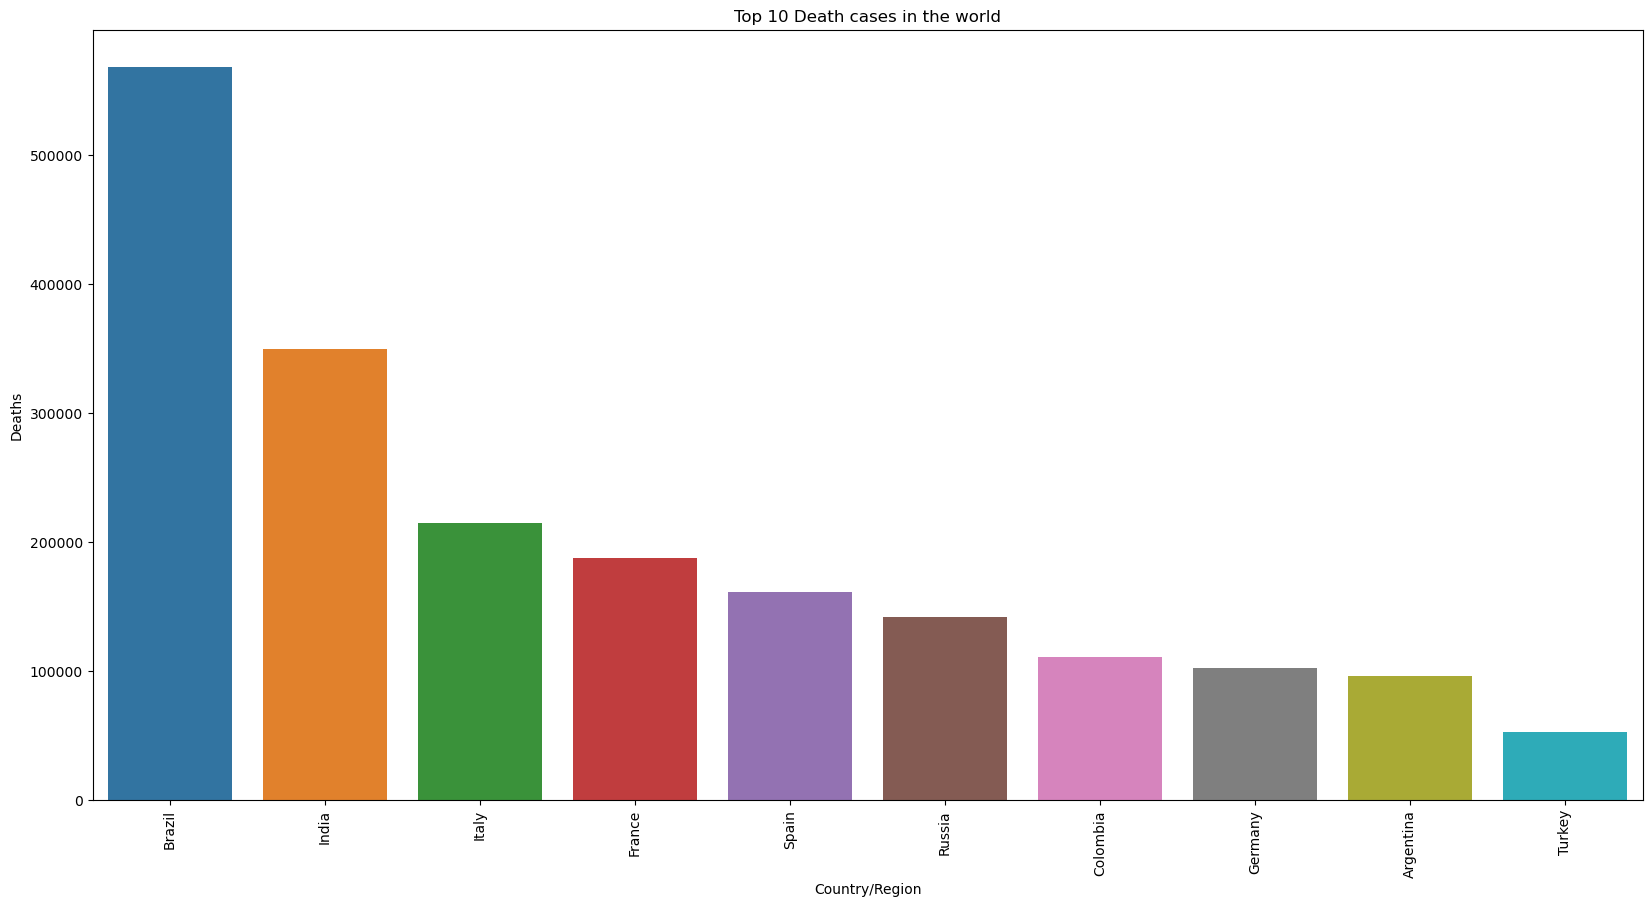

In [39]:
# Display Top 10 Deaths in the world
sorted_data = csvhtmlDF.head(10).sort_values("Deaths", ascending = False)
plt.figure(figsize=(20,10))
sns.barplot(x=sorted_data['Country/Region'], y=sorted_data['Deaths'])
plt.xticks(rotation= 90)
plt.xlabel('Country/Region')
plt.ylabel('Deaths')
plt.title('Top 10 Death cases in the world')


Text(0.5, 1.0, 'Top 10 Confirmed cases in the world')

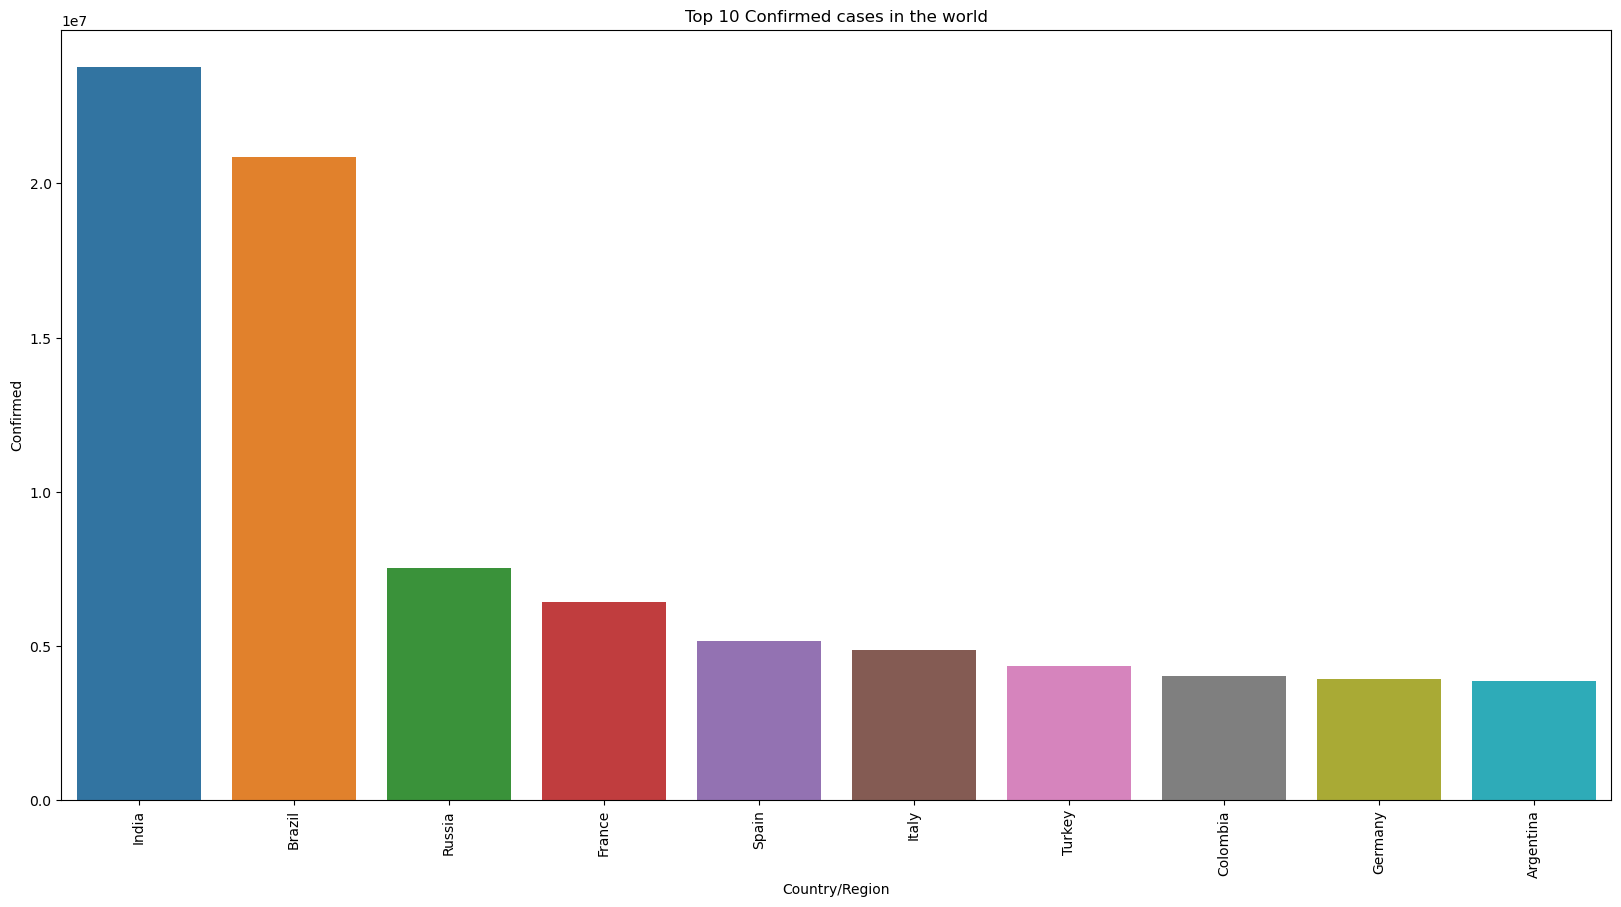

In [40]:
 # dislay confirmed in first 10 countries
sorted_data = csvhtmlDF.head(10).sort_values("Confirmed", ascending = False)
plt.figure(figsize=(20,10))
sns.barplot(x=sorted_data['Country/Region'], y=sorted_data['Confirmed'])
plt.xticks(rotation= 90)
plt.xlabel('Country/Region')
plt.ylabel('Confirmed')
plt.title('Top 10 Confirmed cases in the world')


Text(0.5, 1.0, 'Top 10 Recovered cases in the world')

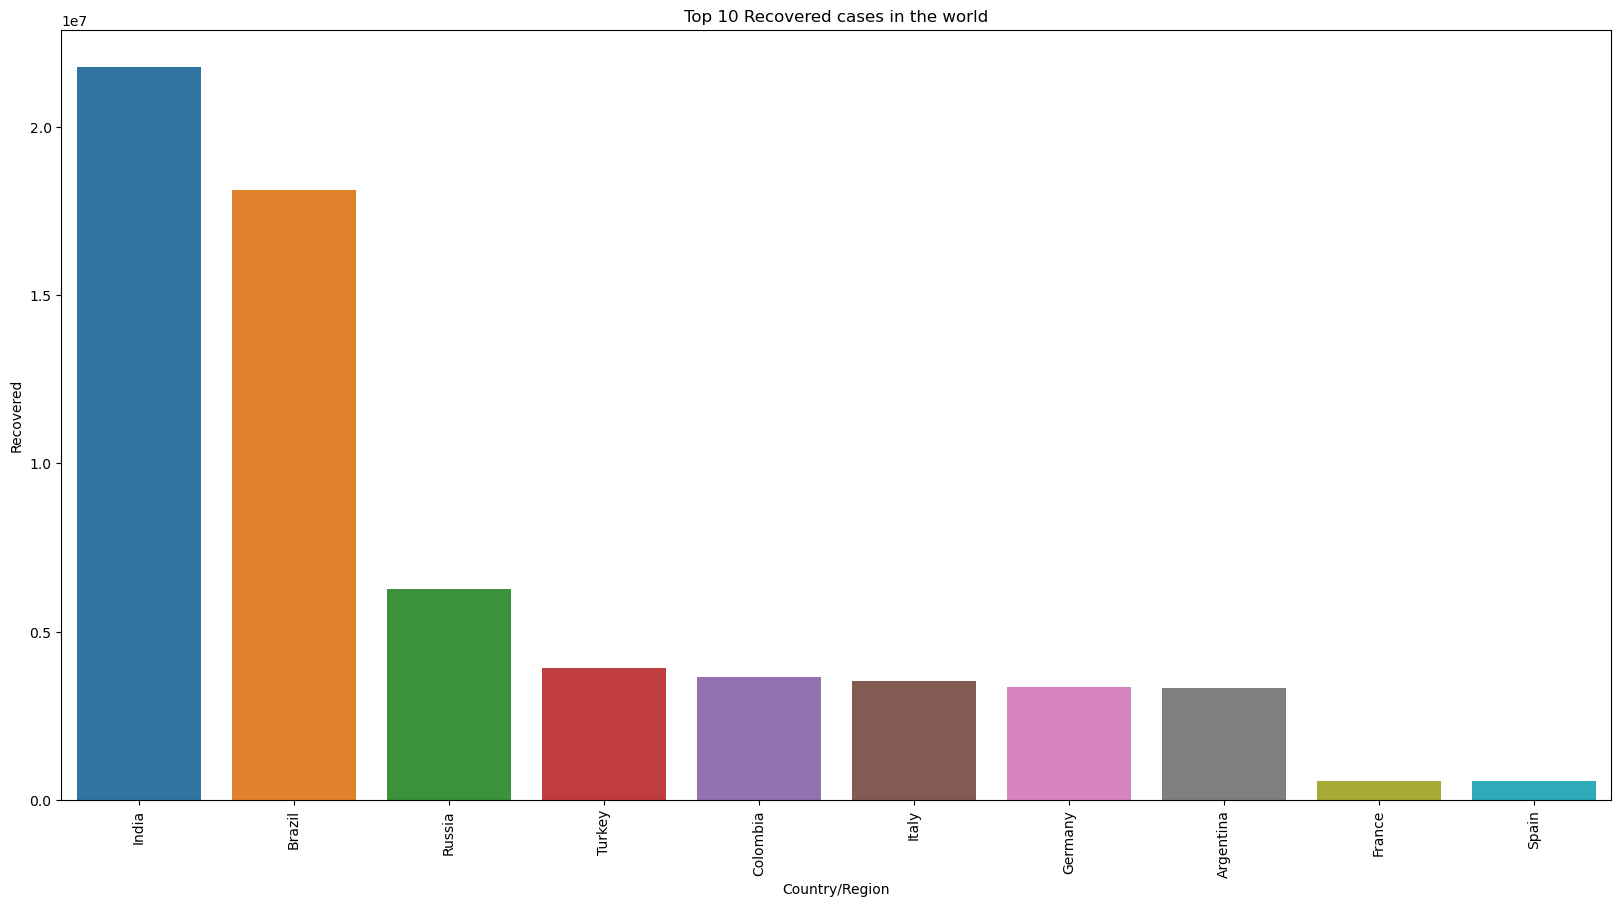

In [41]:
# Top 10 recovered countries in the world
#dislay Recovered in first 10 countries
sorted_data = csvhtmlDF.head(10).sort_values("Recovered", ascending = False)
plt.figure(figsize=(20,10))
sns.barplot(x=sorted_data['Country/Region'], y=sorted_data['Recovered'])
plt.xticks(rotation= 90)
plt.xlabel('Country/Region')
plt.ylabel('Recovered')
plt.title('Top 10 Recovered cases in the world')


Text(0.5, 1.0, 'Top 10 Active cases in the world')

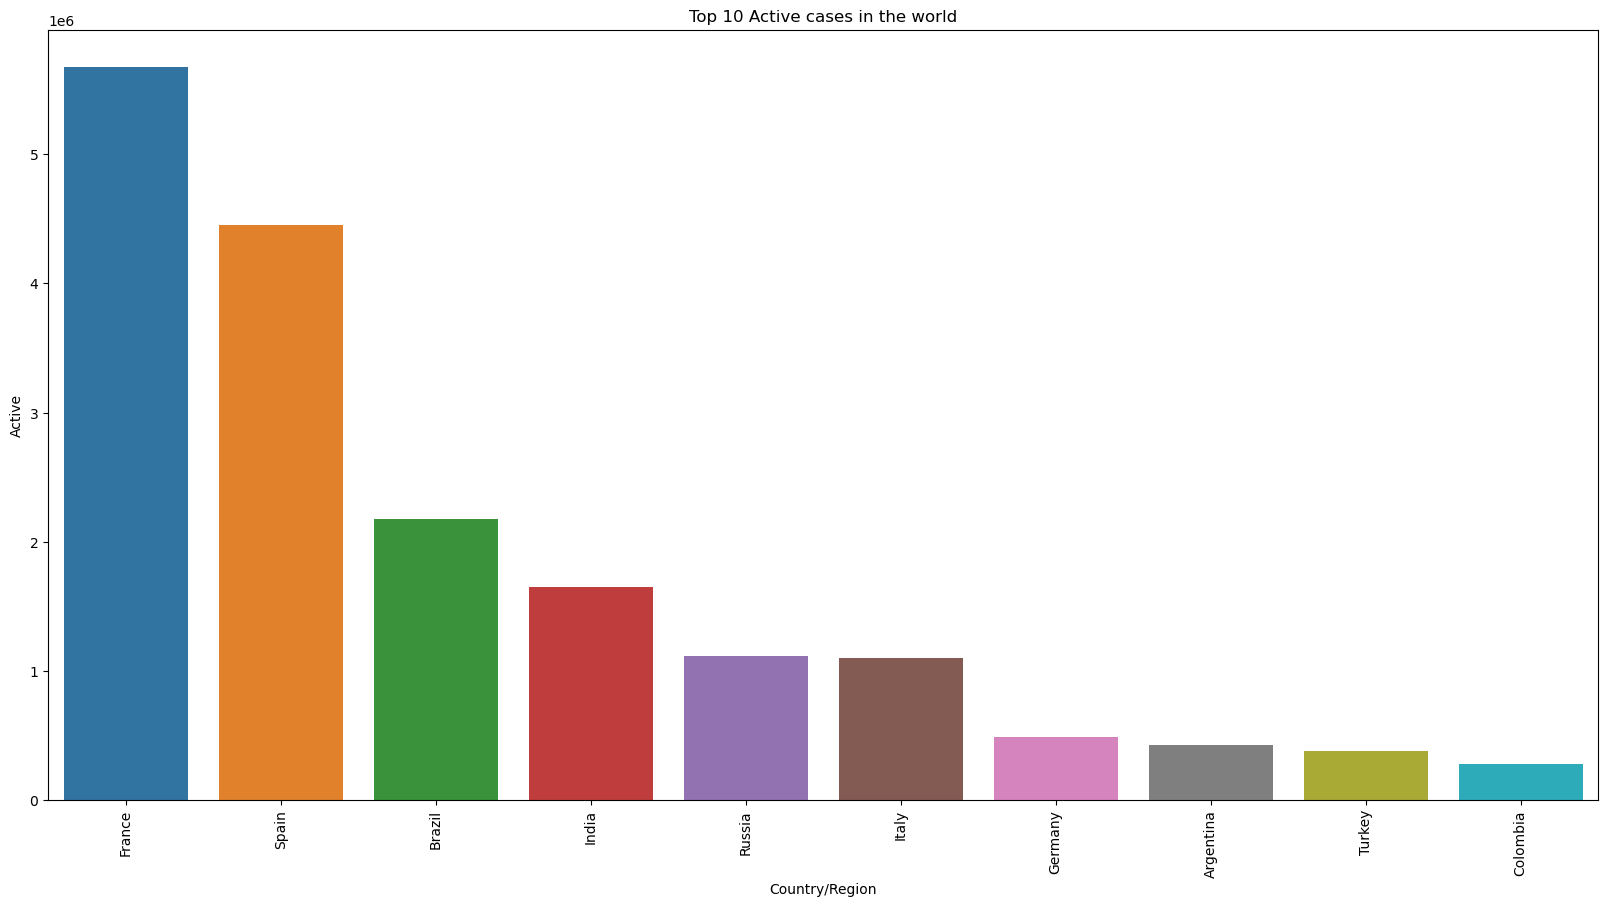

In [42]:
## Visualizing Data
# Lets examine the top 5 countries with max confirmed numbers.
sorted_data = csvhtmlDF.head(10).sort_values("Active", ascending = False)
plt.figure(figsize=(20,10))
sns.barplot(x=sorted_data['Country/Region'], y=sorted_data['Active'])
plt.xticks(rotation= 90)
plt.xlabel('Country/Region')
plt.ylabel('Active')
plt.title('Top 10 Active cases in the world')


array([[<Axes: xlabel='Confirmed', ylabel='Confirmed'>,
        <Axes: xlabel='Deaths', ylabel='Confirmed'>,
        <Axes: xlabel='Recovered', ylabel='Confirmed'>,
        <Axes: xlabel='Active', ylabel='Confirmed'>],
       [<Axes: xlabel='Confirmed', ylabel='Deaths'>,
        <Axes: xlabel='Deaths', ylabel='Deaths'>,
        <Axes: xlabel='Recovered', ylabel='Deaths'>,
        <Axes: xlabel='Active', ylabel='Deaths'>],
       [<Axes: xlabel='Confirmed', ylabel='Recovered'>,
        <Axes: xlabel='Deaths', ylabel='Recovered'>,
        <Axes: xlabel='Recovered', ylabel='Recovered'>,
        <Axes: xlabel='Active', ylabel='Recovered'>],
       [<Axes: xlabel='Confirmed', ylabel='Active'>,
        <Axes: xlabel='Deaths', ylabel='Active'>,
        <Axes: xlabel='Recovered', ylabel='Active'>,
        <Axes: xlabel='Active', ylabel='Active'>]], dtype=object)

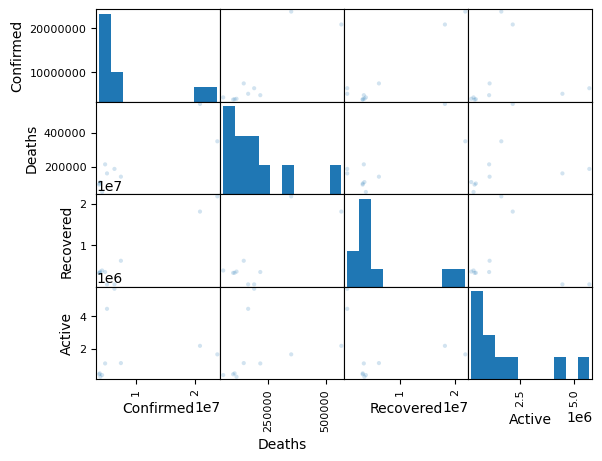

In [43]:
#Scatter matrix plot between the confirmed, deaths and recovery category.
#fig = px.scatter_matrix(csvhtmlDF.head(10), dimensions=['Confirmed', 'Deaths','Recovered', 'Active'], color = "Country/Region")
#fig

df = pd.DataFrame(csvhtmlDF.head(10), columns=['Confirmed', 'Deaths','Recovered', 'Active'])
pd.plotting.scatter_matrix(df, alpha=0.2)


In [44]:
# Defining COVID-19 cases as per classifications
cases = ['Confirmed', 'Deaths', 'Recovered', 'Active']
full_table = csvhtmlDF
# Defining Active Case: Active Case = confirmed - deaths - recovered
#full_table['Active'] = full_table['TotalCases'] - full_table['TotalDeaths'] -full_table['TotalRecovered'

# cases in the ships
#ship = full_table[full_table['Province/State'].str.contains('GrandPrincess')|full_table['Country/Region'].str.contains('Cruise Ship')]

# china and the row
china = full_table[full_table['Country/Region']=='China']
row = full_table[full_table['Country/Region']!='China']

# latest
full_latest = full_table
#full_table = [full_table['Date'] == max(full_table['Date'])].reset_index()
#china_latest = full_table[full_latest['Country/Region']=='China']
row_latest = full_table[full_latest['Country/Region']!='China']

# latest condensed
full_latest_grouped = full_latest.groupby('Country/Region')['Confirmed','Deaths', 'Recovered', 'Active'].sum().reset_index()
#china_latest_grouped = china_latest.groupby('Province/State')['Confirmed','Deaths', 'Recovered', 'Active'].sum().reset_index()
row_latest_grouped = row_latest.groupby('Country/Region')['Confirmed','Deaths', 'Recovered', 'Active'].sum().reset_index()



C:\Users\vidya\AppData\Local\Temp\ipykernel_7672\1423770390.py:21: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  full_latest_grouped = full_latest.groupby('Country/Region')['Confirmed','Deaths', 'Recovered', 'Active'].sum().reset_index()
C:\Users\vidya\AppData\Local\Temp\ipykernel_7672\1423770390.py:23: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  row_latest_grouped = row_latest.groupby('Country/Region')['Confirmed','Deaths', 'Recovered', 'Active'].sum().reset_index()


In [45]:
temp = full_table.groupby(['Country/Region'])['Confirmed', 'Deaths','Recovered', 'Active'].max()
#temp = full_table.groupby('Date')['Confirmed', 'Deaths', 'Recovered','Active'].sum().reset_index()
#temp = temp[temp['Date']==max(temp['Date'])].reset_index(drop=True)
temp.style.background_gradient(cmap='Pastel1')


C:\Users\vidya\AppData\Local\Temp\ipykernel_7672\3549422859.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  temp = full_table.groupby(['Country/Region'])['Confirmed', 'Deaths','Recovered', 'Active'].max()


,Confirmed,Deaths,Recovered,Active
Country/Region,,,,
Afghanistan,147040.450000,5687.890000,114468.530000,26884.030000
Albania,148988.580000,2865.410000,95544.170000,50579.000000
Algeria,230813.630000,7110.820000,157524.270000,66178.540000
Andorra,18835.950000,274.250000,16818.780000,1742.920000
Angola,36782.900000,923.590000,27494.180000,8365.130000
Argentina,3853357.910000,95726.470000,3329542.690000,428088.750000
Armenia,344373.190000,6137.460000,295331.340000,42904.390000
Australia,83409.400000,2347.630000,63577.680000,17484.090000
Austria,746609.220000,12944.290000,667039.010000,66625.920000


In [46]:
temp_f = full_latest_grouped.sort_values(by='Confirmed', ascending=False)
temp_f = temp_f.reset_index(drop=True)
temp_f.head(11).style.background_gradient(cmap='Reds')


,Country/Region,Confirmed,Deaths,Recovered,Active
0,India,23794177.150000,349770.700000,21792205.730000,1652200.720000
1,Brazil,20866755.420000,568910.000000,18122137.660000,2175707.760000
2,Russia,7513763.320000,142133.260000,6255125.120000,1116504.940000
3,France,6425219.830000,187745.240000,557444.630000,5680029.960000
4,Spain,5165795.250000,161451.940000,555447.270000,4448896.040000
5,Italy,4847829.650000,214516.540000,3538063.230000,1095249.880000
6,Turkey,4339089.980000,52447.070000,3905145.550000,381497.360000
7,Colombia,4031122.540000,110602.570000,3644554.440000,275965.530000
8,Germany,3936204.510000,102121.780000,3347286.860000,486795.870000
9,Argentina,3853357.910000,95726.470000,3329542.690000,428088.750000


In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import time
from datetime import datetime
from scipy import integrate, optimize
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
plt.rcParams["figure.figsize"] = (10,5)
pd.options.display.max_columns = 1000


Text(0.5, 1.0, 'Fatalities')

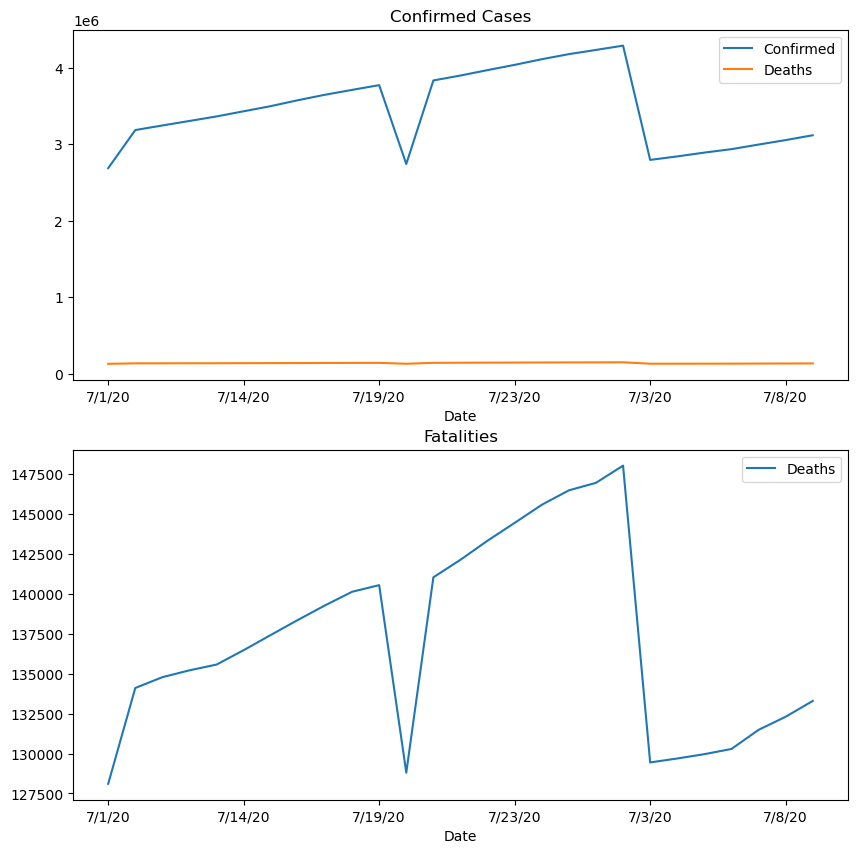

In [48]:
fig, axes = plt.subplots(2, 1, figsize = (10, 10))
uscountyDF.groupby("Date").agg({"Confirmed": "sum","Deaths": "sum"}).plot(ax =fig.axes[0])
uscountyDF.groupby("Date").agg({"Deaths": "sum"}).plot(ax = fig.axes[1])
fig.axes[0].set_title("Confirmed Cases")
fig.axes[1].set_title("Fatalities")
